In [20]:

# Imports & Paths
import os, re, string, json, unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight

from nltk.stem import PorterStemmer

# Optional (uncomment if using SMOTE)
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline

# Paths
DATA_PATH = "../data/processed/balanced_dataset.csv"
PREP_PATH = "../data/processed/balanced_dataset_preprocessed.csv"
LABEL_MAP_PATH = "../data/processed/label_mapping.json"
MODEL_PATH = "../data/processed/best_model.joblib"
VECT_PATH  = "../data/processed/tfidf_vectorizer.joblib"


In [21]:

# Load dataset
df = pd.read_csv(DATA_PATH)
df.head()


,id,title,selftext,label
0,1mg7mpq,I used to scam people and i scammed a girl tha...,"( i typed this message almost a year ago , the...",normal
1,1n8rg56,I don't know if I have depression,I was recently kicked out of school and have b...,depression
2,1n7yii5,Are people actually happy with life?,Ive never felt true happiness in my life for a...,normal
3,1j9q5g9,Embarassed to meet my friends because I do not...,I'm 26f. One of my friends who lives abroad is...,depression
4,1my3p4i,"Anyone else find the rise of ""you don't owe an...",It seems to be frequently framed in a positive...,normal


In [22]:

# Step 1 — Data Preprocessing: cleaner

URL_RE = re.compile(r'https?://\S+|www\.\S+')
MENTION_HASHTAG_RE = re.compile(r'[@#]\w+')
NUM_RE = re.compile(r'\d+')
PUNCT_TABLE = str.maketrans('', '', string.punctuation)

EMOJI_RE = re.compile(
    "["
    "\U0001F300-\U0001F5FF"
    "\U0001F600-\U0001F64F"
    "\U0001F680-\U0001F6FF"
    "\U0001F700-\U0001F77F"
    "\U0001F780-\U0001F7FF"
    "\U0001F800-\U0001F8FF"
    "\U0001F900-\U0001F9FF"
    "\U0001FA00-\U0001FA6F"
    "\U0001FA70-\U0001FAFF"
    "\U00002700-\U000027BF"
    "\U00002600-\U000026FF"
    "]+",
    flags=re.UNICODE
)

ps = PorterStemmer()

def normalize_whitespace(text: str) -> str:
    return re.sub(r'\\s+', ' ', text).strip()

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = URL_RE.sub(" ", text)
    text = MENTION_HASHTAG_RE.sub(" ", text)
    # one-line emoji remover:
    text = re.sub(r'[\\U00010000-\\U0010FFFF]', '', text)
    text = EMOJI_RE.sub(" ", text)
    text = NUM_RE.sub(" ", text)
    text = text.translate(PUNCT_TABLE)
    tokens = []
    for tok in text.split():
        if tok in ENGLISH_STOP_WORDS:
            continue
        if len(tok) <= 1:
            continue
        tokens.append(ps.stem(tok))
    return normalize_whitespace(" ".join(tokens))


In [25]:

# Combine title + selftext -> raw_text; clean; encode labels

for col in ["title", "selftext"]:
    if col not in df.columns: df[col] = ""

df["raw_text"] = (df["title"].fillna("") + " " + df["selftext"].fillna("")).str.strip()
df["clean_text"] = df["raw_text"].apply(clean_text)
df = df[df["clean_text"].str.len() > 0].reset_index(drop=True)

label_order = ["normal", "anxiety", "depression", "suicidal"]
label_to_id = {lbl:i for i, lbl in enumerate(label_order)}
id_to_label = {i:lbl for lbl, i in label_to_id.items()}

df["label_norm"] = df["label"].str.lower().str.strip()
df["label_id"] = df["label_norm"].map(label_to_id)

df_final = df[["id", "clean_text", "label_id"]].rename(columns={"clean_text":"text", "label_id":"label"})

df_final.to_csv(PREP_PATH, index=False)
with open(LABEL_MAP_PATH, "w") as f:
    json.dump({"label_to_id": label_to_id, "id_to_label": id_to_label}, f, indent=2)

df_final.head(5)


,id,text,label
0,1mg7mpq,use scam peopl scam girl lung cancer pass away...,0
1,1n8rg56,dont know depress recent kick school feel depr...,2
2,1n7yii5,peopl actual happi life ive felt true happi li...,0
3,1j9q5g9,embarass meet friend im friend live abroad sta...,2
4,1my3p4i,rise dont owe owe cultur realli depress freque...,0


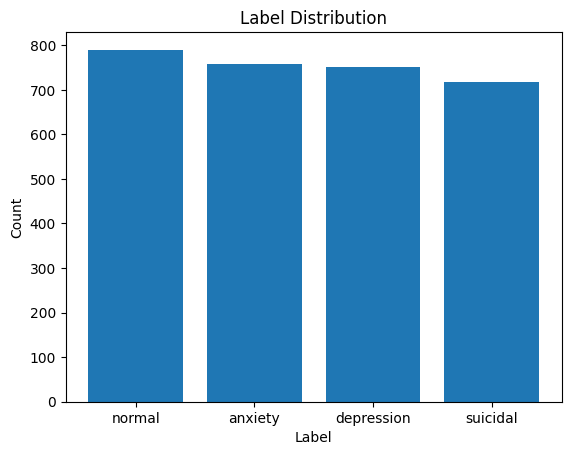

In [26]:

# Step 2 — EDA: Label distribution
label_counts = df_final["label"].value_counts().sort_index()
labels_text = [id_to_label[i] for i in label_counts.index]

plt.figure()
plt.bar(labels_text, label_counts.values)
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


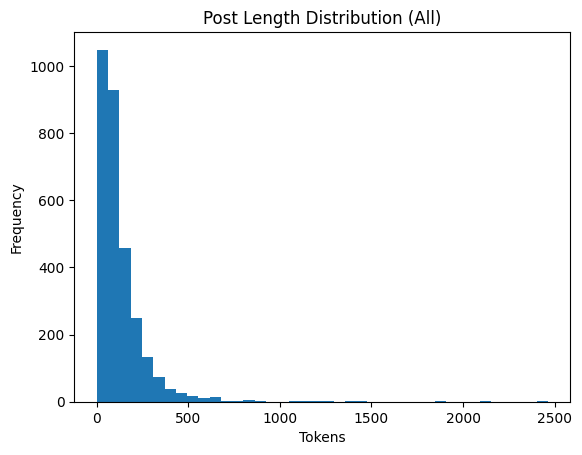

In [27]:

# Step 2 — EDA: Length distribution (token count)
df_final["token_count"] = df_final["text"].str.split().apply(len)

plt.figure()
plt.hist(df_final["token_count"], bins=40)
plt.title("Post Length Distribution (All)")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()


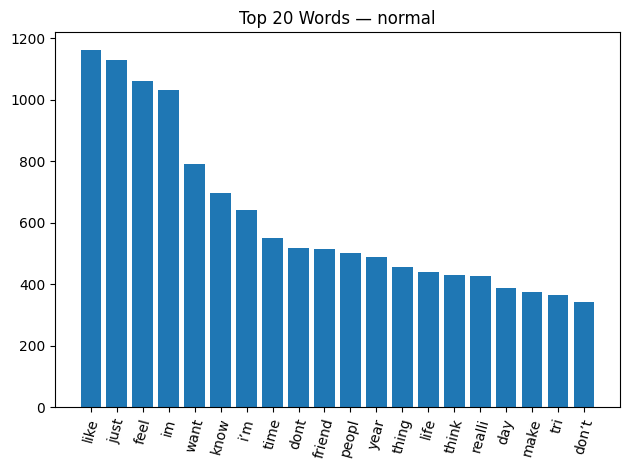

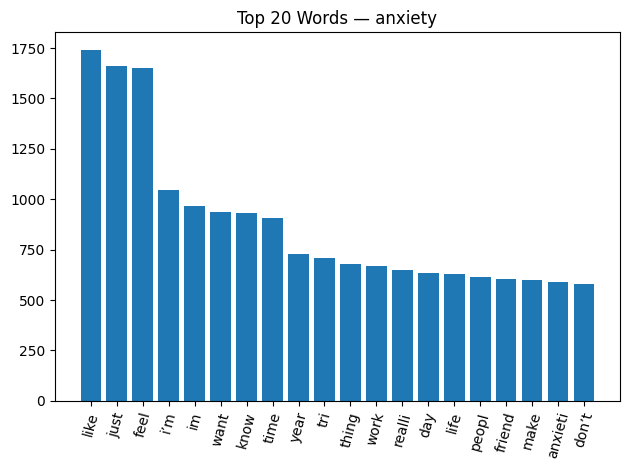

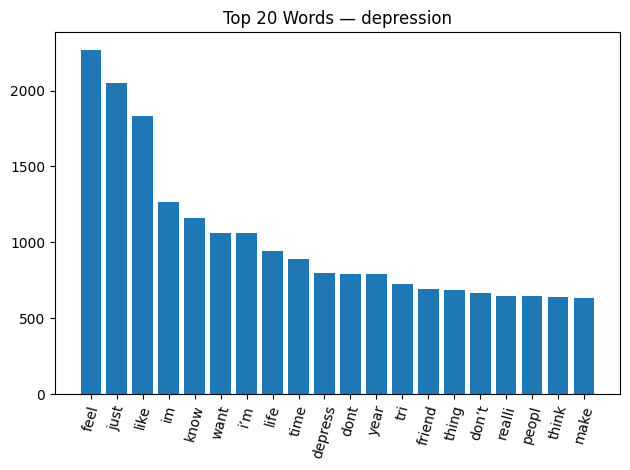

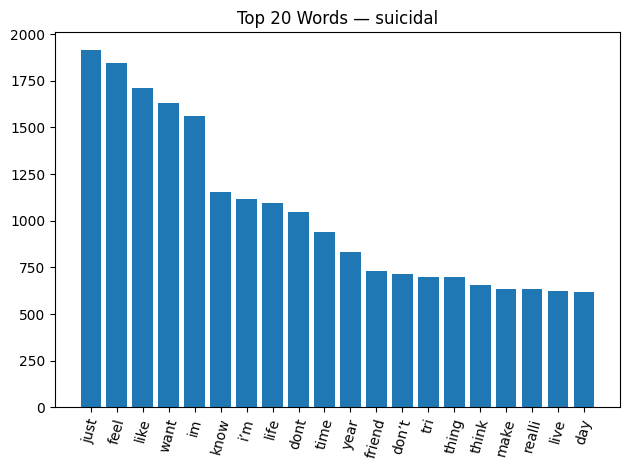

In [28]:

# Step 2 — EDA: Top words per label
topk = 20
for i, lbl in id_to_label.items():
    tokens = " ".join(df_final[df_final["label"] == i]["text"].tolist()).split()
    ctr = Counter(tokens)
    words, freqs = zip(*ctr.most_common(topk)) if ctr else ([], [])
    plt.figure()
    plt.bar(words, freqs)
    plt.title(f"Top {topk} Words — {lbl}")
    plt.xticks(rotation=75)
    plt.tight_layout()
    plt.show()


In [29]:

# Step 3 — Feature Engineering (TF-IDF); Step 4 — Baselines; Step 5 — Evaluation

X = df_final["text"].values
y = df_final["label"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

len(X_train), len(X_val), len(X_test)


(2412, 302, 302)

In [30]:

# TF-IDF vectorizer
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)


In [31]:

def evaluate(model, X_tr, y_tr, X_va, y_va, name="model"):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_va)
    print(name)
    print(classification_report(y_va, preds, target_names=[id_to_label[i] for i in sorted(set(y))]))
    print("Confusion Matrix:\n", confusion_matrix(y_va, preds))
    macro_f1 = f1_score(y_va, preds, average="macro")
    print("Macro F1:", macro_f1)
    return macro_f1

# Pipelines
pipe_lr = Pipeline([("tfidf", tfidf), ("clf", LogisticRegression(max_iter=300, n_jobs=None))])
pipe_svm = Pipeline([("tfidf", tfidf), ("clf", LinearSVC())])
pipe_nb = Pipeline([("tfidf", tfidf), ("clf", MultinomialNB())])

f1_lr  = evaluate(pipe_lr,  X_train, y_train, X_val, y_val, name="LogisticRegression")
f1_svm = evaluate(pipe_svm, X_train, y_train, X_val, y_val, name="LinearSVC")
f1_nb  = evaluate(pipe_nb,  X_train, y_train, X_val, y_val, name="MultinomialNB")

f1_lr, f1_svm, f1_nb


LogisticRegression
              precision    recall  f1-score   support

      normal       0.72      0.66      0.69        79
     anxiety       0.72      0.72      0.72        76
  depression       0.57      0.65      0.61        75
    suicidal       0.75      0.71      0.73        72

    accuracy                           0.69       302
   macro avg       0.69      0.69      0.69       302
weighted avg       0.69      0.69      0.69       302

Confusion Matrix:
 [[52  7 12  8]
 [ 9 55 10  2]
 [ 8 11 49  7]
 [ 3  3 15 51]]
Macro F1: 0.6874232532814906
LinearSVC
              precision    recall  f1-score   support

      normal       0.69      0.66      0.68        79
     anxiety       0.71      0.68      0.70        76
  depression       0.58      0.64      0.61        75
    suicidal       0.76      0.75      0.76        72

    accuracy                           0.68       302
   macro avg       0.69      0.68      0.68       302
weighted avg       0.69      0.68      0.68    

(0.6874232532814906, 0.6840377361148748, 0.5292628068541805)